In [460]:
import pandas as pd
import math
from sklearn import cross_validation, linear_model
from sklearn.linear_model import LogisticRegression
import csv
import random
import numpy as np
import matplotlib as plt
import seaborn as sns
% matplotlib inline

I used code adapted from this Kaggle user: https://www.kaggle.com/mineshjethva/2018-logistics-lb-public-1-5
I added features based on spreads of assists, personal foals, and defensive rebounds.
The model already incorporated seed differences and score spreads.

In [461]:

#the seed information
df_seeds = pd.read_csv('WNCAATourneySeeds2018.csv')
print(df_seeds.shape)
print(df_seeds.head())
#print(df_seeds.Season.value_counts())

#tour information
df_tour = pd.read_csv('WRegularSeasonDetailedResults.csv')
print(df_tour.shape)
print(df_tour.head())

(1344, 3)
   Season Seed  TeamID
0    1998  W01    3330
1    1998  W02    3163
2    1998  W03    3112
3    1998  W04    3301
4    1998  W05    3272
(46342, 34)
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2010      11     3103      63     3237      49    H      0    23    54   
1    2010      11     3104      73     3399      68    N      0    26    62   
2    2010      11     3110      71     3224      59    A      0    29    62   
3    2010      11     3111      63     3267      58    A      0    27    52   
4    2010      11     3119      74     3447      70    H      1    30    74   

  ...   LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0 ...      13     6    10   11   27    11   23     7     6   19  
1 ...      21    14    27   14   26     7   20     4     2   27  
2 ...      14    19    23   17   23     8   15     6     0   15  
3 ...      26    16    25   22   22    15   11    14     5   14  
4 ...      17    11    21   21   32

In [462]:
df_seeds['seed_int'] = df_seeds['Seed'].apply( lambda x : int(x[1:3]) )

df_winseeds = df_seeds.loc[:, ['TeamID', 'Season', 'seed_int']].rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.loc[:, ['TeamID', 'Season', 'seed_int']].rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
print(df_concat.shape)
print(df_concat.head())

(4398, 36)
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2010      11     3173      77     3277      74    H      0    26    65   
1    2010      17     3323      68     3277      67    A      0    22    65   
2    2010      34     3231      68     3277      63    A      0    19    60   
3    2010      56     3458      62     3277      54    H      0    20    46   
4    2010      68     3326      65     3277      62    A      0    18    52   

   ...    LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  WSeed  LSeed  
0  ...      26   17   28    16   22     7     9   29    8.0      5  
1  ...      22   14   31    13   21     6     9   22    2.0      5  
2  ...      27   27   24    10   10     6    10   24    NaN      5  
3  ...      17   10   20    11   26     7     3   21    7.0      5  
4  ...      26   14   23     9   17     9     4   20    2.0      5  

[5 rows x 36 columns]


In [463]:
df_concat['DiffSeed'] = df_concat[['LSeed', 'WSeed']].apply(lambda x : 0 if x[0] == x[1] else 1, axis = 1)
print(df_concat.shape)
print(df_concat.head())
print(df_concat.Season.value_counts())

(4398, 37)
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2010      11     3173      77     3277      74    H      0    26    65   
1    2010      17     3323      68     3277      67    A      0    22    65   
2    2010      34     3231      68     3277      63    A      0    19    60   
3    2010      56     3458      62     3277      54    H      0    20    46   
4    2010      68     3326      65     3277      62    A      0    18    52   

     ...     LOR  LDR  LAst  LTO  LStl  LBlk  LPF  WSeed  LSeed  DiffSeed  
0    ...      17   28    16   22     7     9   29    8.0      5         1  
1    ...      14   31    13   21     6     9   22    2.0      5         1  
2    ...      27   24    10   10     6    10   24    NaN      5         1  
3    ...      10   20    11   26     7     3   21    7.0      5         1  
4    ...      14   23     9   17     9     4   20    2.0      5         1  

[5 rows x 37 columns]
2011    501
2014    499
2017    499

In [464]:
df_sample_sub1 = pd.read_csv('WSampleSubmissionStage1.csv')

#prepares sample submission
df_sample_sub2 = pd.read_csv('WSampleSubmissionStage2.csv')

df_sample_sub=pd.concat([df_sample_sub1, df_sample_sub2])

print(df_sample_sub.shape)
print(df_sample_sub.head())

(10080, 2)
               ID  Pred
0  2014_3103_3107   0.5
1  2014_3103_3113   0.5
2  2014_3103_3119   0.5
3  2014_3103_3124   0.5
4  2014_3103_3140   0.5


In [465]:
df_sample_sub['Season'] = df_sample_sub['ID'].apply(lambda x : int(x.split('_')[0]) )
df_sample_sub['TeamID1'] = df_sample_sub['ID'].apply(lambda x : int(x.split('_')[1]) )
df_sample_sub['TeamID2'] = df_sample_sub['ID'].apply(lambda x : int(x.split('_')[2]) )
print(df_sample_sub.shape)
print(df_sample_sub.head())

(10080, 5)
               ID  Pred  Season  TeamID1  TeamID2
0  2014_3103_3107   0.5    2014     3103     3107
1  2014_3103_3113   0.5    2014     3103     3113
2  2014_3103_3119   0.5    2014     3103     3119
3  2014_3103_3124   0.5    2014     3103     3124
4  2014_3103_3140   0.5    2014     3103     3140


In [466]:
winners = df_concat.rename( columns = { 'WTeamID' : 'TeamID1', 
                                                       'LTeamID' : 'TeamID2',
                                                      'WScore' : 'Team1_Score',
                                                      'LScore' : 'Team2_Score',
                                                      'WAst': 'Team1_Ast',
                                                      'LAst': 'Team2_Ast',
                                                      'WDR': 'Team1_DR',
                                                      'LDR': 'Team2_DR',
                                                      'WPF': 'Team1_PF',
                                                      'LPF': 'Team2_PF'}).drop(['WSeed', 'LSeed', 'WLoc', 'LBlk', 'LFGA', 'LFGA3', 'LFGM', 'LFGM3',
       'LFTA', 'LFTM', 'LOR', 'LStl', 'LTO', 'WBlk', 'WFGA', 'WFGA3', 'WFGM', 'WFGM3',
       'WFTA', 'WFTM', 'WOR', 'WStl', 'WTO'], axis = 1)
winners['Result'] = 1.0

losers = df_concat.rename( columns = { 'WTeamID' : 'TeamID2', 
                                                       'LTeamID' : 'TeamID1',
                                                      'WScore' : 'Team2_Score',
                                                      'LScore' : 'Team1_Score',
                                                    'WAst': 'Team2_Ast',
                                                      'LAst': 'Team1_Ast',
                                                      'WDR': 'Team2_DR',
                                                      'LDR': 'Team1_DR',
                                                     'WPF': 'Team2_PF',
                                                      'LPF': 'Team1_PF',}).drop(['WSeed', 'LSeed', 'WLoc', 'LBlk', 'LFGA', 'LFGA3', 'LFGM', 'LFGM3',
       'LFTA', 'LFTM', 'LOR', 'LStl', 'LTO', 'WBlk', 'WFGA', 'WFGA3', 'WFGM', 'WFGM3',
       'WFTA', 'WFTM', 'WOR', 'WStl', 'WTO'], axis = 1)

losers['Result'] = 0.0

train = pd.concat( [winners, losers], axis = 0).reset_index(drop = True)

train['Score_Ratio'] = train['Team1_Score'] / train['Team2_Score']
train['Score_Total'] = train['Team1_Score'] + train['Team2_Score']
train['Score_Pct'] = train['Team1_Score'] / train['Score_Total']

train['DR_Ratio'] = train['Team1_DR'] / train['Team2_DR']
train['DR_Total'] = train['Team1_DR'] + train['Team2_DR']
train['DR_Pct'] = train['Team1_DR'] / train['DR_Total']

train['Ast_Ratio'] = train['Team1_Ast'] / train['Team2_Ast']
train['Ast_Total'] = train['Team1_Ast'] + train['Team2_Ast']
train['Ast_Pct'] = train['Team1_Ast'] / train['Ast_Total']

train['PF_Ratio'] = train['Team1_PF'] / train['Team2_PF']
train['PF_Total'] = train['Team1_PF'] + train['Team2_PF']
train['PF_Pct'] = train['Team1_PF'] / train['PF_Total']

print(train.shape)
print(train.head())

(8796, 27)
   DayNum  DiffSeed  NumOT  Result  Season  Team1_Ast  Team1_DR  Team1_PF  \
0      11         1      0     1.0    2010         14        31        22   
1      17         1      0     1.0    2010         12        29        20   
2      34         1      0     1.0    2010          6        26        22   
3      56         1      0     1.0    2010         12        16        20   
4      68         1      0     1.0    2010          8        27        20   

   Team1_Score  Team2_Ast    ...     Score_Pct  DR_Ratio  DR_Total    DR_Pct  \
0           77         16    ...      0.509934  1.107143        59  0.525424   
1           68         13    ...      0.503704  0.935484        60  0.483333   
2           68         10    ...      0.519084  1.083333        50  0.520000   
3           62         11    ...      0.534483  0.800000        36  0.444444   
4           65          9    ...      0.511811  1.173913        50  0.540000   

   Ast_Ratio  Ast_Total   Ast_Pct  PF_Ratio  

In [467]:
train.columns

Index(['DayNum', 'DiffSeed', 'NumOT', 'Result', 'Season', 'Team1_Ast',
       'Team1_DR', 'Team1_PF', 'Team1_Score', 'Team2_Ast', 'Team2_DR',
       'Team2_PF', 'Team2_Score', 'TeamID1', 'TeamID2', 'Score_Ratio',
       'Score_Total', 'Score_Pct', 'DR_Ratio', 'DR_Total', 'DR_Pct',
       'Ast_Ratio', 'Ast_Total', 'Ast_Pct', 'PF_Ratio', 'PF_Total', 'PF_Pct'],
      dtype='object')

In [468]:
train.isnull().sum()

DayNum         0
DiffSeed       0
NumOT          0
Result         0
Season         0
Team1_Ast      0
Team1_DR       0
Team1_PF       0
Team1_Score    0
Team2_Ast      0
Team2_DR       0
Team2_PF       0
Team2_Score    0
TeamID1        0
TeamID2        0
Score_Ratio    0
Score_Total    0
Score_Pct      0
DR_Ratio       0
DR_Total       0
DR_Pct         0
Ast_Ratio      0
Ast_Total      0
Ast_Pct        0
PF_Ratio       0
PF_Total       0
PF_Pct         0
dtype: int64

In [469]:
train.Score_Ratio.describe()

count    8796.000000
mean        1.026322
std         0.241386
min         0.242991
25%         0.867647
50%         1.000049
75%         1.152542
max         4.115385
Name: Score_Ratio, dtype: float64

In [470]:
years = [2014, 2015, 2016, 2017,2018]

In [471]:
train_test_inner = pd.merge( train.loc[ train['Season'].isin(years), : ].reset_index(drop = True), 
         df_sample_sub.drop(['ID', 'Pred'], axis = 1), 
         on = ['Season', 'TeamID1', 'TeamID2'], how = 'inner' )

In [472]:
train_test_inner.isnull().sum()

DayNum         0
DiffSeed       0
NumOT          0
Result         0
Season         0
Team1_Ast      0
Team1_DR       0
Team1_PF       0
Team1_Score    0
Team2_Ast      0
Team2_DR       0
Team2_PF       0
Team2_Score    0
TeamID1        0
TeamID2        0
Score_Ratio    0
Score_Total    0
Score_Pct      0
DR_Ratio       0
DR_Total       0
DR_Pct         0
Ast_Ratio      0
Ast_Total      0
Ast_Pct        0
PF_Ratio       0
PF_Total       0
PF_Pct         0
dtype: int64

In [473]:
train_test_inner.head()
train_test_inner.shape

(1380, 27)

In [474]:
train_test_inner.columns

Index(['DayNum', 'DiffSeed', 'NumOT', 'Result', 'Season', 'Team1_Ast',
       'Team1_DR', 'Team1_PF', 'Team1_Score', 'Team2_Ast', 'Team2_DR',
       'Team2_PF', 'Team2_Score', 'TeamID1', 'TeamID2', 'Score_Ratio',
       'Score_Total', 'Score_Pct', 'DR_Ratio', 'DR_Total', 'DR_Pct',
       'Ast_Ratio', 'Ast_Total', 'Ast_Pct', 'PF_Ratio', 'PF_Total', 'PF_Pct'],
      dtype='object')

In [475]:
#From the inner join, we will create data per team id to estimate the parameters we are missing that are independent of the year. Essentially, we are trying to estimate the average behavior of the team across the year.

team1d_num_ot = train_test_inner.groupby(['Season', 'TeamID1'])['NumOT'].median().reset_index()\
.set_index('Season').rename(columns = {'NumOT' : 'NumOT1'})
team2d_num_ot = train_test_inner.groupby(['Season', 'TeamID2'])['NumOT'].median().reset_index()\
.set_index('Season').rename(columns = {'NumOT' : 'NumOT2'})

num_ot = team1d_num_ot.join(team2d_num_ot).reset_index()

#sum the number of ot calls and subtract by one to prevent overcounting
num_ot['NumOT'] = num_ot[['NumOT1', 'NumOT2']].apply(lambda x : round( x.sum() ), axis = 1 )

num_ot.head()

,Season,TeamID1,NumOT1,TeamID2,NumOT2,NumOT
0,2014,3103,0.0,3143,0.0,0
1,2014,3103,0.0,3163,0.0,0
2,2014,3103,0.0,3169,0.0,0
3,2014,3103,0.0,3173,0.0,0
4,2014,3103,0.0,3181,0.0,0


In [476]:
#Here we look at the comparable statistics. For the TeamID2 column, we would consider the inverse of the ratio, and 1 minus the score attempt percentage.

def geo_mean( x ):
    return np.exp( np.mean(np.log(x)) )

def harm_mean( x ):
    return np.mean( x ** -1.0 ) ** -1.0

team1d_score_spread = train_test_inner.groupby(['Season', 'TeamID1'])[['Score_Ratio', 'Score_Pct']]\
.agg({ 'Score_Ratio': geo_mean, 'Score_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'Score_Ratio' : 'Score_Ratio1', 'Score_Pct' : 'Score_Pct1'})

team2d_score_spread = train_test_inner.groupby(['Season', 'TeamID2'])[['Score_Ratio', 'Score_Pct']]\
.agg({ 'Score_Ratio': geo_mean, 'Score_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'Score_Ratio' : 'Score_Ratio2', 'Score_Pct' : 'Score_Pct2'})


score_spread = team1d_score_spread.join(team2d_score_spread).reset_index()

#geometric mean of score ratio of team 1 and inverse of team 2
score_spread['Score_Ratio'] = score_spread[['Score_Ratio1', 'Score_Ratio2']].apply(lambda x : ( x[0] * ( x[1] ** -1.0) ), axis = 1 ) ** 0.5

#harmonic mean of score pct
score_spread['Score_Pct'] = score_spread[['Score_Pct1', 'Score_Pct2']].apply(lambda x : 0.5*( x[0] ** -1.0 ) + 0.5*( 1.0 - x[1] ) ** -1.0, axis = 1 ) ** -1.0


In [477]:
team1d_ast_spread = train_test_inner.groupby(['Season', 'TeamID1'])[['Ast_Ratio', 'Ast_Pct']]\
.agg({ 'Ast_Ratio': geo_mean, 'Ast_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'Ast_Ratio' : 'Ast_Ratio1', 'Ast_Pct' : 'Ast_Pct1'})

team2d_ast_spread = train_test_inner.groupby(['Season', 'TeamID2'])[['Ast_Ratio', 'Ast_Pct']]\
.agg({ 'Ast_Ratio': geo_mean, 'Ast_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'Ast_Ratio' : 'Ast_Ratio2', 'Ast_Pct' : 'Ast_Pct2'})


ast_spread = team1d_ast_spread.join(team2d_ast_spread).reset_index()

#geometric mean of score ratio of team 1 and inverse of team 2
score_spread['Ast_Ratio'] = ast_spread[['Ast_Ratio1', 'Ast_Ratio2']].apply(lambda x : ( x[0] * ( x[1] ** -1.0) ), axis = 1 ) ** 0.5

#harmonic mean of score pct
score_spread['Ast_Pct'] = ast_spread[['Ast_Pct1', 'Ast_Pct2']].apply(lambda x : 0.5*( x[0] ** -1.0 ) + 0.5*( 1.0 - x[1] ) ** -1.0, axis = 1 ) ** -1.0




In [478]:
team1d_DR_spread = train_test_inner.groupby(['Season', 'TeamID1'])[['DR_Ratio', 'DR_Pct']]\
.agg({ 'DR_Ratio': geo_mean, 'DR_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'DR_Ratio' : 'DR_Ratio1', 'DR_Pct' : 'DR_Pct1'})

team2d_DR_spread = train_test_inner.groupby(['Season', 'TeamID2'])[['DR_Ratio', 'DR_Pct']]\
.agg({ 'DR_Ratio': geo_mean, 'DR_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'DR_Ratio' : 'DR_Ratio2', 'DR_Pct' : 'DR_Pct2'})


DR_spread = team1d_DR_spread.join(team2d_DR_spread).reset_index()

#geometric mean of score ratio of team 1 and inverse of team 2
score_spread['DR_Ratio'] = DR_spread[['DR_Ratio1', 'DR_Ratio2']].apply(lambda x : ( x[0] * ( x[1] ** -1.0) ), axis = 1 ) ** 0.5
#harmonic mean of score pct
score_spread['DR_Pct'] = DR_spread[['DR_Pct1', 'DR_Pct2']].apply(lambda x : 0.5*( x[0] ** -1.0 ) + 0.5*( 1.0 - x[1] ) ** -1.0, axis = 1 ) ** -1.0


In [479]:
team1d_PF_spread = train_test_inner.groupby(['Season', 'TeamID1'])[['PF_Ratio', 'PF_Pct']]\
.agg({ 'PF_Ratio': geo_mean, 'PF_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'PF_Ratio' : 'PF_Ratio1', 'PF_Pct' : 'PF_Pct1'})

team2d_PF_spread = train_test_inner.groupby(['Season', 'TeamID2'])[['PF_Ratio', 'PF_Pct']]\
.agg({ 'PF_Ratio': geo_mean, 'PF_Pct' : harm_mean}).reset_index()\
.set_index('Season').rename(columns = {'PF_Ratio' : 'PF_Ratio2', 'PF_Pct' : 'PF_Pct2'})


PF_spread = team1d_PF_spread.join(team2d_PF_spread).reset_index()

#geometric mean of score ratio of team 1 and inverse of team 2
score_spread['PF_Ratio'] = PF_spread[['PF_Ratio1', 'PF_Ratio2']].apply(lambda x : ( x[0] * ( x[1] ** -1.0) ), axis = 1 ) ** 0.5

#harmonic mean of score pct
score_spread['PF_Pct'] = PF_spread[['PF_Pct1', 'PF_Pct2']].apply(lambda x : 0.5*( x[0] ** -1.0 ) + 0.5*( 1.0 - x[1] ) ** -1.0, axis = 1 ) ** -1.0




In [480]:
score_spread.isnull().sum()

Season          0
TeamID1         0
Score_Ratio1    0
Score_Pct1      0
TeamID2         0
Score_Ratio2    0
Score_Pct2      0
Score_Ratio     0
Score_Pct       0
Ast_Ratio       0
Ast_Pct         0
DR_Ratio        0
DR_Pct          0
PF_Ratio        0
PF_Pct          0
dtype: int64

In [481]:
train_test_inner.columns

Index(['DayNum', 'DiffSeed', 'NumOT', 'Result', 'Season', 'Team1_Ast',
       'Team1_DR', 'Team1_PF', 'Team1_Score', 'Team2_Ast', 'Team2_DR',
       'Team2_PF', 'Team2_Score', 'TeamID1', 'TeamID2', 'Score_Ratio',
       'Score_Total', 'Score_Pct', 'DR_Ratio', 'DR_Total', 'DR_Pct',
       'Ast_Ratio', 'Ast_Total', 'Ast_Pct', 'PF_Ratio', 'PF_Total', 'PF_Pct'],
      dtype='object')

In [482]:
X_train = train_test_inner.loc[:, ['Season', 'NumOT', 'Score_Ratio', 'Score_Pct', 'Ast_Ratio',
       'Ast_Pct', 'DR_Ratio', 'DR_Pct', 'PF_Ratio', 'PF_Pct']] 
train_labels = train_test_inner['Result']
X_train.isnull().sum()

Season         0
NumOT          0
Score_Ratio    0
Score_Pct      0
Ast_Ratio      0
Ast_Pct        0
DR_Ratio       0
DR_Pct         0
PF_Ratio       0
PF_Pct         0
dtype: int64

In [483]:
train_test_outer = pd.merge( train.loc[ train['Season'].isin(years), : ].reset_index(drop = True), 
         df_sample_sub.drop(['ID', 'Pred'], axis = 1), 
         on = ['Season', 'TeamID1', 'TeamID2'], how = 'outer' )

In [484]:
train_test_outer.isnull().sum()

DayNum         9043
DiffSeed       9043
NumOT          9043
Result         9043
Season            0
Team1_Ast      9043
Team1_DR       9043
Team1_PF       9043
Team1_Score    9043
Team2_Ast      9043
Team2_DR       9043
Team2_PF       9043
Team2_Score    9043
TeamID1           0
TeamID2           0
Score_Ratio    9043
Score_Total    9043
Score_Pct      9043
DR_Ratio       9043
DR_Total       9043
DR_Pct         9043
Ast_Ratio      9043
Ast_Total      9043
Ast_Pct        9043
PF_Ratio       9043
PF_Total       9043
PF_Pct         9043
dtype: int64

In [485]:
train_test_outer = train_test_outer.loc[ train_test_outer['Result'].isnull(), 
                                        ['TeamID1', 'TeamID2', 'Season']]

In [486]:
train_test_outer.isnull().sum()

TeamID1    0
TeamID2    0
Season     0
dtype: int64

In [487]:
train_test_missing = pd.merge( pd.merge(score_spread.loc[:, ['TeamID1', 'TeamID2', 'Season', 'Score_Ratio', 'Score_Pct', 'Ast_Ratio',
       'Ast_Pct', 'DR_Ratio', 'DR_Pct', 'PF_Ratio', 'PF_Pct']], 
                   train_test_outer, on = ['TeamID1', 'TeamID2', 'Season']),
         num_ot.loc[:, ['TeamID1', 'TeamID2', 'Season', 'NumOT']],
         on = ['TeamID1', 'TeamID2', 'Season'])

In [488]:
train_test_missing.isnull().sum()

TeamID1        0
TeamID2        0
Season         0
Score_Ratio    0
Score_Pct      0
Ast_Ratio      0
Ast_Pct        0
DR_Ratio       0
DR_Pct         0
PF_Ratio       0
PF_Pct         0
NumOT          0
dtype: int64

In [489]:
train_test_missing.head()

,TeamID1,TeamID2,Season,Score_Ratio,Score_Pct,Ast_Ratio,Ast_Pct,DR_Ratio,DR_Pct,PF_Ratio,PF_Pct,NumOT
0,3103,3143,2014,0.937046,0.484342,0.889416,0.447515,1.000711,0.495040,1.057927,0.523009,0
1,3103,3163,2014,1.114925,0.520949,1.340258,0.540817,1.058948,0.507087,0.895009,0.468967,0
2,3103,3169,2014,0.836696,0.455329,0.914889,0.448542,0.682533,0.393040,0.985273,0.494603,0
3,3103,3181,2014,0.985393,0.499427,1.061666,0.500333,1.044097,0.510465,0.958931,0.491312,0
4,3103,3199,2014,0.935506,0.483282,0.982900,0.473371,1.036946,0.503235,1.135509,0.531591,0


In [490]:
#We scale our data for our logistic regression, and make sure our categorical variables are properly processed.

X_test = train_test_missing.loc[:, ['Season', 'NumOT', 'Score_Ratio', 'Score_Pct', 'Ast_Ratio', 'DR_Ratio', 'PF_Ratio', 'Ast_Pct', 'DR_Pct', 'PF_Pct']]

In [491]:
X_test.head()

,Season,NumOT,Score_Ratio,Score_Pct,Ast_Ratio,DR_Ratio,PF_Ratio,Ast_Pct,DR_Pct,PF_Pct
0,2014,0,0.937046,0.484342,0.889416,1.000711,1.057927,0.447515,0.495040,0.523009
1,2014,0,1.114925,0.520949,1.340258,1.058948,0.895009,0.540817,0.507087,0.468967
2,2014,0,0.836696,0.455329,0.914889,0.682533,0.985273,0.448542,0.393040,0.494603
3,2014,0,0.985393,0.499427,1.061666,1.044097,0.958931,0.500333,0.510465,0.491312
4,2014,0,0.935506,0.483282,0.982900,1.036946,1.135509,0.473371,0.503235,0.531591


In [492]:
n = X_train.shape[0]

In [493]:
train_test_merge = pd.concat( [X_train, X_test], axis = 0 ).reset_index(drop = True)

In [494]:
train_test_merge = pd.concat( [pd.get_dummies( train_test_merge['Season'].astype(object) ), 
            train_test_merge.drop('Season', axis = 1) ], axis = 1 )

In [495]:
train_test_merge = pd.concat( [pd.get_dummies( train_test_merge['NumOT'].astype(object) ), 
            train_test_merge.drop('NumOT', axis = 1) ], axis = 1 )

X_train = train_test_merge.loc[:(n - 1), :].reset_index(drop = True)
X_test = train_test_merge.loc[n:, :].reset_index(drop = True)

In [496]:
train_test_merge.isnull().sum()

0              0
1              0
2              0
3              0
4              0
2014           0
2015           0
2016           0
2017           0
2018           0
Ast_Pct        0
Ast_Ratio      0
DR_Pct         0
DR_Ratio       0
PF_Pct         0
PF_Ratio       0
Score_Pct      0
Score_Ratio    0
dtype: int64

In [497]:
x_max = X_train.max()
x_min = X_train.min()

X_train = ( X_train - x_min ) / ( x_max - x_min + 1e-14)
X_test = ( X_test - x_min ) / ( x_max - x_min + 1e-14)

In [498]:
print(X_train.shape)
print(X_train.head())

print(train_labels.shape)
print(train_labels.head())
print(train_labels.value_counts())

print(X_test.shape)
print(X_test.head())

(1380, 18)
     0    1    2    3    4  2014  2015  2016  2017  2018   Ast_Pct  Ast_Ratio  \
0  1.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   0.0  0.565777   0.114526   
1  1.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   0.0  0.416327   0.066122   
2  1.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   0.0  0.595918   0.127697   
3  1.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   0.0  0.560653   0.112430   
4  1.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   0.0  0.522449   0.097959   

     DR_Pct  DR_Ratio    PF_Pct  PF_Ratio  Score_Pct  Score_Ratio  
0  0.740524  0.436087  0.521062  0.249917   0.618894     0.369421  
1  0.482878  0.201931  0.413239  0.177417   0.574964     0.327960  
2  0.535398  0.237955  0.442943  0.195827   0.541489     0.298757  
3  0.575221  0.268437  0.762301  0.495495   0.613417     0.364042  
4  0.604078  0.292501  0.436374  0.191662   0.587111     0.339051  
(1380,)
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Result, dtype: float64
0.0    693
1

In [499]:
from sklearn.linear_model import LogisticRegressionCV

log_clf = LogisticRegressionCV(cv = 5,Cs=8,n_jobs=4,scoring="neg_log_loss")

log_clf.fit( X_train, train_labels )

LogisticRegressionCV(Cs=8, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

In [500]:
print(log_clf.scores_[1])

[[-0.69319232 -0.69384506 -0.69426906 -0.65223014 -0.5802668  -0.3883429
  -0.18465013 -0.04041747]
 [-0.69377894 -0.70137892 -0.74050641 -0.67751376 -0.56304702 -0.42552432
  -0.28420844 -0.22979473]
 [-0.69301696 -0.69152739 -0.66928477 -0.57173751 -0.42656562 -0.26914993
  -0.18042533 -0.05072779]
 [-0.69217085 -0.68015817 -0.57593277 -0.36652923 -0.19334575 -0.10206284
  -0.06793893 -0.07886935]
 [-0.69201616 -0.67810423 -0.55805588 -0.35199471 -0.21179919 -0.08065747
  -0.03913599 -0.0389182 ]]


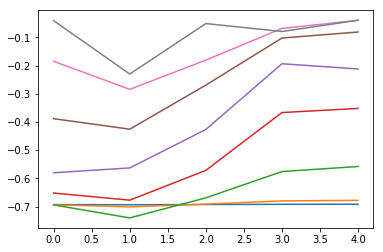

In [501]:
import matplotlib.pyplot as plt
plt.plot(log_clf.scores_[1])
# plt.ylabel('some numbers')
plt.show()

In [502]:
train_test_inner['Pred1'] = log_clf.predict_proba(X_train)[:,1]
train_test_missing['Pred1'] = log_clf.predict_proba(X_test)[:,1]

In [503]:
sub = pd.merge(df_sample_sub, 
                         pd.concat( [train_test_missing.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']],
                                     train_test_inner.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']] ],
                                   axis = 0).reset_index(drop = True),
                  on = ['Season', 'TeamID1', 'TeamID2'], how = 'outer')

In [504]:
print(sub.shape)
print(sub.head())

(10423, 6)
               ID  Pred  Season  TeamID1  TeamID2  Pred1
0  2014_3103_3107   0.5    2014     3103     3107    NaN
1  2014_3103_3113   0.5    2014     3103     3113    NaN
2  2014_3103_3119   0.5    2014     3103     3119    NaN
3  2014_3103_3124   0.5    2014     3103     3124    NaN
4  2014_3103_3140   0.5    2014     3103     3140    NaN


In [505]:
#We get the 'average' probability of success for each team

team1_probs = sub.groupby('TeamID1')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()
team2_probs = sub.groupby('TeamID2')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()
#Any missing value for the prediciton will be imputed with the product of the probabilities calculated above. We assume these are independent events.

sub['Pred'] = sub[['TeamID1', 'TeamID2','Pred1']]\
.apply(lambda x : team1_probs.get(x[0]) * ( 1 - team2_probs.get(x[1]) ) if np.isnan(x[2]) else x[2], 
       axis = 1)

In [506]:
sub.ID.value_counts()
sub=sub.groupby('ID', as_index=False).agg({"Pred": "mean"})
sub.ID.value_counts()
sub2018=sub.loc[sub['ID'].isin(df_sample_sub2.ID)]
print(sub2018.shape)

(2016, 2)


In [507]:
sub2018.head()

,ID,Pred
8064,2018_3110_3113,9.348854e-43
8065,2018_3110_3114,9.348854e-43
8066,2018_3110_3124,9.348854e-43
8067,2018_3110_3125,9.348854e-43
8068,2018_3110_3129,9.348854e-43


In [508]:
sub2018.Pred.mean()

0.36850240102023485

In [509]:
sub2018.Pred.describe()

count    2.016000e+03
mean     3.685024e-01
std      4.511544e-01
min      2.331184e-50
25%      6.869387e-12
50%      5.945273e-04
75%      9.984556e-01
max      1.000000e+00
Name: Pred, dtype: float64

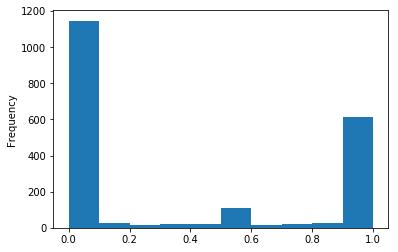

In [510]:
sub2018['Pred'].plot.hist()

In [511]:
#sub2018[['ID', 'Pred']].to_csv('sub_2018_all_only18.csv', index = False)

In [512]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=train_labels)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [513]:
train_test_inner['Pred1'] = clf.predict(X_train)
train_test_missing['Pred1'] = clf.predict(X_test)

sub2 = pd.merge(df_sample_sub, pd.concat( [train_test_missing.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']],
                                     train_test_inner.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']] ],
                                   axis = 0).reset_index(drop = True),
                  on = ['Season', 'TeamID1', 'TeamID2'], how = 'outer')

#We get the 'average' probability of success for each team

team1_probs = sub2.groupby('TeamID1')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()
team2_probs = sub2.groupby('TeamID2')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()
#Any missing value for the prediciton will be imputed with the product of the probabilities calculated above. We assume these are independent events.

sub['Pred'] = sub2[['TeamID1', 'TeamID2','Pred1']]\
.apply(lambda x : team1_probs.get(x[0]) * ( 1 - team2_probs.get(x[1]) ) if np.isnan(x[2]) else x[2], 
       axis = 1)

In [514]:
sub.ID.value_counts()
sub=sub.groupby('ID', as_index=False).agg({"Pred": "mean"})
sub.ID.value_counts()
sub2018_lgb=sub.loc[sub['ID'].isin(df_sample_sub2.ID)]
print(sub2018.shape)

(2016, 2)


In [515]:
sub2018_lgb.head()

,ID,Pred
8064,2018_3110_3113,0.377013
8065,2018_3110_3114,0.420593
8066,2018_3110_3124,0.396654
8067,2018_3110_3125,0.396582
8068,2018_3110_3129,0.386071


In [516]:
sub2018_lgb.Pred.mean()

0.4484592580025936

In [517]:
#sub2018_lgb[['ID', 'Pred']].to_csv('sub_2018_lgb.csv', index = False)

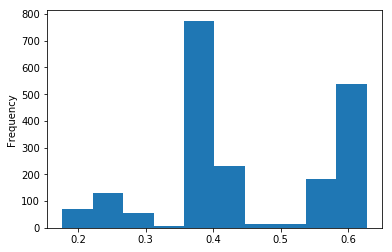

In [518]:
sub2018_lgb['Pred'].plot.hist()

In [519]:
sub2018_lgb.Pred.describe()

count    2016.000000
mean        0.448459
std         0.125140
min         0.176626
25%         0.376549
50%         0.397124
75%         0.585225
max         0.627403
Name: Pred, dtype: float64

In [520]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 200
params['max_depth'] = 50
clf = lgb.train(params, d_train, 100)

In [521]:
train_test_inner['Pred1'] = clf.predict(X_train)
train_test_missing['Pred1'] = clf.predict(X_test)

sub = pd.merge(df_sample_sub, pd.concat( [train_test_missing.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']],
                                     train_test_inner.loc[:, ['Season', 'TeamID1', 'TeamID2', 'Pred1']] ],
                                   axis = 0).reset_index(drop = True),
                  on = ['Season', 'TeamID1', 'TeamID2'], how = 'outer')

#We get the 'average' probability of success for each team

team1_probs = sub.groupby('TeamID1')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()
team2_probs = sub.groupby('TeamID2')['Pred1'].apply(lambda x : (x ** -1.0).mean() ** -1.0 ).fillna(0.5).to_dict()
#Any missing value for the prediciton will be imputed with the product of the probabilities calculated above. We assume these are independent events.

sub['Pred'] = sub[['TeamID1', 'TeamID2','Pred1']]\
.apply(lambda x : team1_probs.get(x[0]) * ( 1 - team2_probs.get(x[1]) ) if np.isnan(x[2]) else x[2], 
       axis = 1)

In [522]:
sub.ID.value_counts()
sub=sub.groupby('ID', as_index=False).agg({"Pred": "mean"})
sub.ID.value_counts()
sub2018_lgb3=sub.loc[sub['ID'].isin(df_sample_sub2.ID)]
print(sub2018.shape)

(2016, 2)


In [523]:
sub2018_lgb3.Pred.mean()

0.4508362721958463

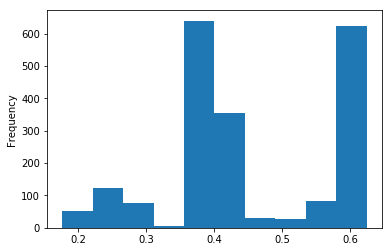

In [524]:
sub2018_lgb3['Pred'].plot.hist()

In [526]:
sub2018_lgb[['ID', 'Pred']].to_csv('sub_2018_lgb3.csv', index = False)

In [528]:
!pip install binarytree
!pip install bracketeer

  Running setup.py bdist_wheel for binarytree: started
  Running setup.py bdist_wheel for binarytree: finished with status 'done'
  Stored in directory: C:\Users\MissFlave\AppData\Local\pip\Cache\wheels\6f\af\aa\27c4aa57282254c29bf429bd6a54ef30b70a41fd1e11a00539
Successfully built binarytree
  Running setup.py bdist_wheel for bracketeer: started
  Running setup.py bdist_wheel for bracketeer: finished with status 'done'
  Stored in directory: C:\Users\MissFlave\AppData\Local\pip\Cache\wheels\b3\83\ad\71c4245864d3b61f2f93df4620912261d76148d5eeeae526e3
Successfully built bracketeer


In [536]:
from bracketeer import build_bracket
b = build_bracket(
        outputPath='output.png',
        teamsPath='./WStage2DataFiles/WTeams.csv',
        seedsPath='./WStage2DataFiles/WNCAATourneySeeds.csv',
        submissionPath='sub_2018_lgb3.csv',
        slotsPath='./WStage2DataFiles/WNCAATourneySlots.csv',
)

from IPython.display import Image
Image("output.png")

KeyError: 'season'